In [1]:
pip install evaluate

Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/data-00000-of-00001.arrow


In [3]:
import os
from datasets import Dataset

def load_geometry3k_dataset():
    """
    Loads the Geometry3K dataset from the Arrow file in the current directory.

    :return: A Hugging Face Dataset object.
    """
    arrow_file_path = "/kaggle/input/dataset/data-00000-of-00001.arrow"

    # Load the dataset from the Arrow file
    dataset = Dataset.from_file(arrow_file_path)

    return dataset

def get_train_val_test_splits(dataset):
    """
    Splits the dataset into train, validation, and test sets.
    - Train: first 2101 samples
    - Validation: next 300 samples
    - Test: remaining samples
    """
    total_samples = dataset.num_rows
    train_end = min(2101, total_samples)
    val_end = min(train_end + 300, total_samples)

    train_dataset = dataset.select(range(0, train_end))
    val_dataset   = dataset.select(range(train_end, val_end))
    test_dataset  = dataset.select(range(val_end, total_samples))

    return {
        "train": train_dataset,
        "validation": val_dataset,
        "test": test_dataset
    }

# Load and split the dataset
dataset = load_geometry3k_dataset()
dataset_splits = get_train_val_test_splits(dataset)

# Show basic info
print("Train samples:", len(dataset_splits["train"]))
print("Validation samples:", len(dataset_splits["validation"]))
print("Test samples:", len(dataset_splits["test"]))

# Display the first training sample
print(dataset_splits["train"][0])


Train samples: 2101
Validation samples: 300
Test samples: 501
{'images': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=648x405 at 0x7F18061F7A00>], 'problem': '<image>Find $x$.', 'answer': '2', 'id': 84, 'choices': ['1', '2', '3', '4'], 'ground_truth': 'B'}


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import AutoProcessor, AutoModel
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
import evaluate
from tqdm.auto import tqdm
from torchvision import transforms


# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seed()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
from torchvision import transforms

# Define image augmentation for the training dataset
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # rotate by up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224))  # Resize to the dimensions expected by your model
])

# Define a transformation for validation/test that only resizes the image
eval_transforms = transforms.Compose([
    transforms.Resize((224, 224))
])


In [6]:
def freeze_early_layers(model, freeze_text_layers=2, freeze_vision_layers=4):
    """
    Freezes early layers of the vision and text encoders in the VLM.
    
    :param model: The GeometryVLM instance.
    :param freeze_text_layers: Number of text encoder layers to freeze.
    :param freeze_vision_layers: Number of vision encoder layers to freeze.
    """
    # Freeze early text layers (assuming layer names in the text encoder follow this pattern)
    for name, param in model.vlm.named_parameters():
        # Check for text encoder layers:
        if "text_model.encoder.layer" in name:
            # Attempt to extract the layer number
            try:
                # Example of name: 'text_model.encoder.layer.0.attention.self.query.weight'
                layer_num = int(name.split('.')[3])
            except Exception:
                continue
            if layer_num < freeze_text_layers:
                param.requires_grad = False
                # Uncomment the next line to debug which parameters are frozen
                # print("Frozen:", name)

        # Freeze early vision layers (assuming similar naming convention)
        if "vision_model.encoder.layer" in name:
            try:
                # Example of name: 'vision_model.encoder.layer.0.attention.self.query.weight'
                layer_num = int(name.split('.')[3])
            except Exception:
                continue
            if layer_num < freeze_vision_layers:
                param.requires_grad = False
                # Uncomment the next line to debug which parameters are frozen
                # print("Frozen:", name)
def freeze_early_layers(model, freeze_text_layers=2, freeze_vision_layers=4):
    """
    Freezes early layers of the vision and text encoders in the VLM.
    
    :param model: The GeometryVLM instance.
    :param freeze_text_layers: Number of text encoder layers to freeze.
    :param freeze_vision_layers: Number of vision encoder layers to freeze.
    """
    # Freeze early text layers (assuming layer names in the text encoder follow this pattern)
    for name, param in model.vlm.named_parameters():
        # Check for text encoder layers:
        if "text_model.encoder.layer" in name:
            # Attempt to extract the layer number
            try:
                # Example of name: 'text_model.encoder.layer.0.attention.self.query.weight'
                layer_num = int(name.split('.')[3])
            except Exception:
                continue
            if layer_num < freeze_text_layers:
                param.requires_grad = False
                # Uncomment the next line to debug which parameters are frozen
                # print("Frozen:", name)

        # Freeze early vision layers (assuming similar naming convention)
        if "vision_model.encoder.layer" in name:
            try:
                # Example of name: 'vision_model.encoder.layer.0.attention.self.query.weight'
                layer_num = int(name.split('.')[3])
            except Exception:
                continue
            if layer_num < freeze_vision_layers:
                param.requires_grad = False
                # Uncomment the next line to debug which parameters are frozen
                # print("Frozen:", name)


In [7]:
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset

class Geometry3KDataset(Dataset):
    def __init__(self, dataset, processor, max_length=64, transform=None):
        """
        :param dataset: The raw dataset (e.g., Hugging Face Dataset).
        :param processor: The processor for text and image.
        :param max_length: Max token length for text processing.
        :param transform: A torchvision transforms pipeline for images.
        """
        self.dataset = dataset
        self.processor = processor
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        item = self.dataset[idx]

        # Get the image (assuming a list and using the first image)
        image = item['images'][0]

        # Convert to PIL Image if necessary, and ensure mode is RGB
        if not isinstance(image, Image.Image):
            image = Image.open(image)
        if image.mode != "RGB":
            image = image.convert("RGB")
        
        # Apply data augmentation transform if provided
        if self.transform:
            image = self.transform(image)
        
        # Process text: combine problem statement with choices
        problem_text = item['problem']
        choices = item['choices']
        full_prompt = problem_text
        for i, choice in enumerate(choices):
            full_prompt += f"\nOption {chr(65+i)}: {choice}"
        
        # Process inputs using the processor
        inputs = self.processor(
            text=full_prompt,
            images=image,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )
        
        # Remove batch dimension from the processor outputs
        for k, v in inputs.items():
            inputs[k] = v.squeeze(0)
        
        # Convert ground truth into label (e.g., for A, B, C, D)
        target_label = ord(item['ground_truth']) - ord('A')
        
        return {
            "inputs": inputs,
            "labels": torch.tensor(target_label, dtype=torch.long),
            "id": item['id']
        }


In [8]:
class GeometryVLM(nn.Module):
    def __init__(self, model_name="google/siglip-base-patch16-224"):
        super(GeometryVLM, self).__init__()
        self.vlm = AutoModel.from_pretrained(model_name)

        # Determine hidden size from the model config
        if hasattr(self.vlm.config, "projection_dim"):
            hidden_size = self.vlm.config.projection_dim
        elif hasattr(self.vlm.config, "vision_config") and hasattr(self.vlm.config.vision_config, "hidden_size"):
            hidden_size = self.vlm.config.vision_config.hidden_size
        elif hasattr(self.vlm.config, "text_config") and hasattr(self.vlm.config.text_config, "hidden_size"):
            hidden_size = self.vlm.config.text_config.hidden_size
        else:
            raise ValueError("Could not determine hidden size from model config.")

        # Classification head for 4 choices (A, B, C, D)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 4)
        )

    def forward(self, inputs):
        pixel_values    = inputs.get("pixel_values")
        input_ids       = inputs.get("input_ids")
        attention_mask  = inputs.get("attention_mask")

        outputs = self.vlm(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            return_dict=True
        )

        # Try to use pooler_output if available;
        # otherwise, fall back to text_embeds if they exist.
        pooled_output = getattr(outputs, "pooler_output", None)
        if pooled_output is None:
            if hasattr(outputs, "text_embeds"):
                pooled_output = outputs.text_embeds
            else:
                raise ValueError("Could not retrieve a pooled output from the SigLIP model.")

        logits = self.classifier(pooled_output)
        return logits


In [9]:
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    for batch in progress_bar:
        # Move batch to device
        inputs = batch["inputs"]
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = batch["labels"].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        logits = model(inputs)
        
        # Compute loss
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Update metrics
        total_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(logits, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({"loss": loss.item(), "accuracy": correct/total})
    
    return total_loss / len(dataloader), correct / total

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Move batch to device
            inputs = batch["inputs"]
            for k, v in inputs.items():
                inputs[k] = v.to(device)
            labels = batch["labels"].to(device)
            
            # Forward pass
            logits = model(inputs)
            
            # Compute loss
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Get predictions
            _, predicted = torch.max(logits, 1)
            
            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    
    return total_loss / len(dataloader), accuracy, all_preds, all_labels

In [10]:
def train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, criterion, scheduler=None, num_epochs=5, device="cuda"):
    best_val_accuracy = 0
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Train
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, criterion, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validate
        val_loss, val_accuracy, _, _ = evaluate_model(model, val_dataloader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        # Update learning rate
        if scheduler:
            scheduler.step(val_loss)
        
        # Save the best model
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_geometry_model.pth")
            print("Saved new best model!")
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves.png')
    plt.show()
    
    return train_losses, train_accuracies, val_losses, val_accuracies

preprocessor_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/711 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/813M [00:00<?, ?B/s]

Epoch 1/10


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.3722, Train Accuracy: 0.3113
Val Loss: 1.3691, Val Accuracy: 0.3067
Saved new best model!
Epoch 2/10


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.3647, Train Accuracy: 0.3113
Val Loss: 1.3607, Val Accuracy: 0.3133
Saved new best model!
Epoch 3/10


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.3560, Train Accuracy: 0.3370
Val Loss: 1.3588, Val Accuracy: 0.3467
Saved new best model!
Epoch 4/10


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.3374, Train Accuracy: 0.3841
Val Loss: 1.3531, Val Accuracy: 0.3667
Saved new best model!
Epoch 5/10


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.3048, Train Accuracy: 0.4555
Val Loss: 1.3525, Val Accuracy: 0.3467
Epoch 6/10


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.2595, Train Accuracy: 0.5212
Val Loss: 1.3461, Val Accuracy: 0.3733
Saved new best model!
Epoch 7/10


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.1884, Train Accuracy: 0.5988
Val Loss: 1.3745, Val Accuracy: 0.3100
Epoch 8/10


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.1061, Train Accuracy: 0.6559
Val Loss: 1.3882, Val Accuracy: 0.3167
Epoch 9/10


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 1.0021, Train Accuracy: 0.7097
Val Loss: 1.3868, Val Accuracy: 0.3367
Epoch 10/10


Training:   0%|          | 0/132 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/19 [00:00<?, ?it/s]

Train Loss: 0.8794, Train Accuracy: 0.8025
Val Loss: 1.3919, Val Accuracy: 0.3600


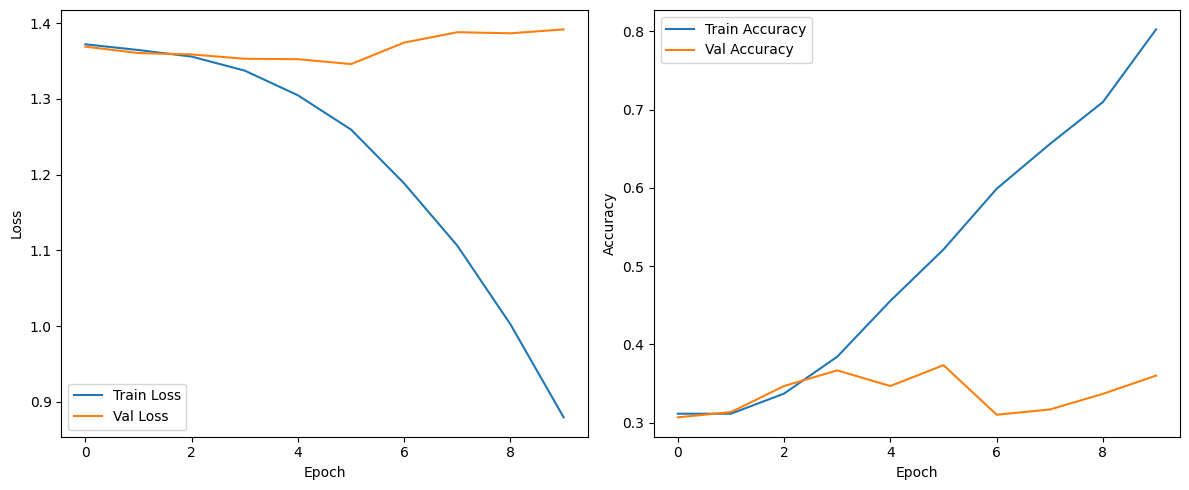

<ipython-input-11-9b3bbd1f7343>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_geometry_model.pth"))


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

Test Loss: 1.3440, Test Accuracy: 0.3553


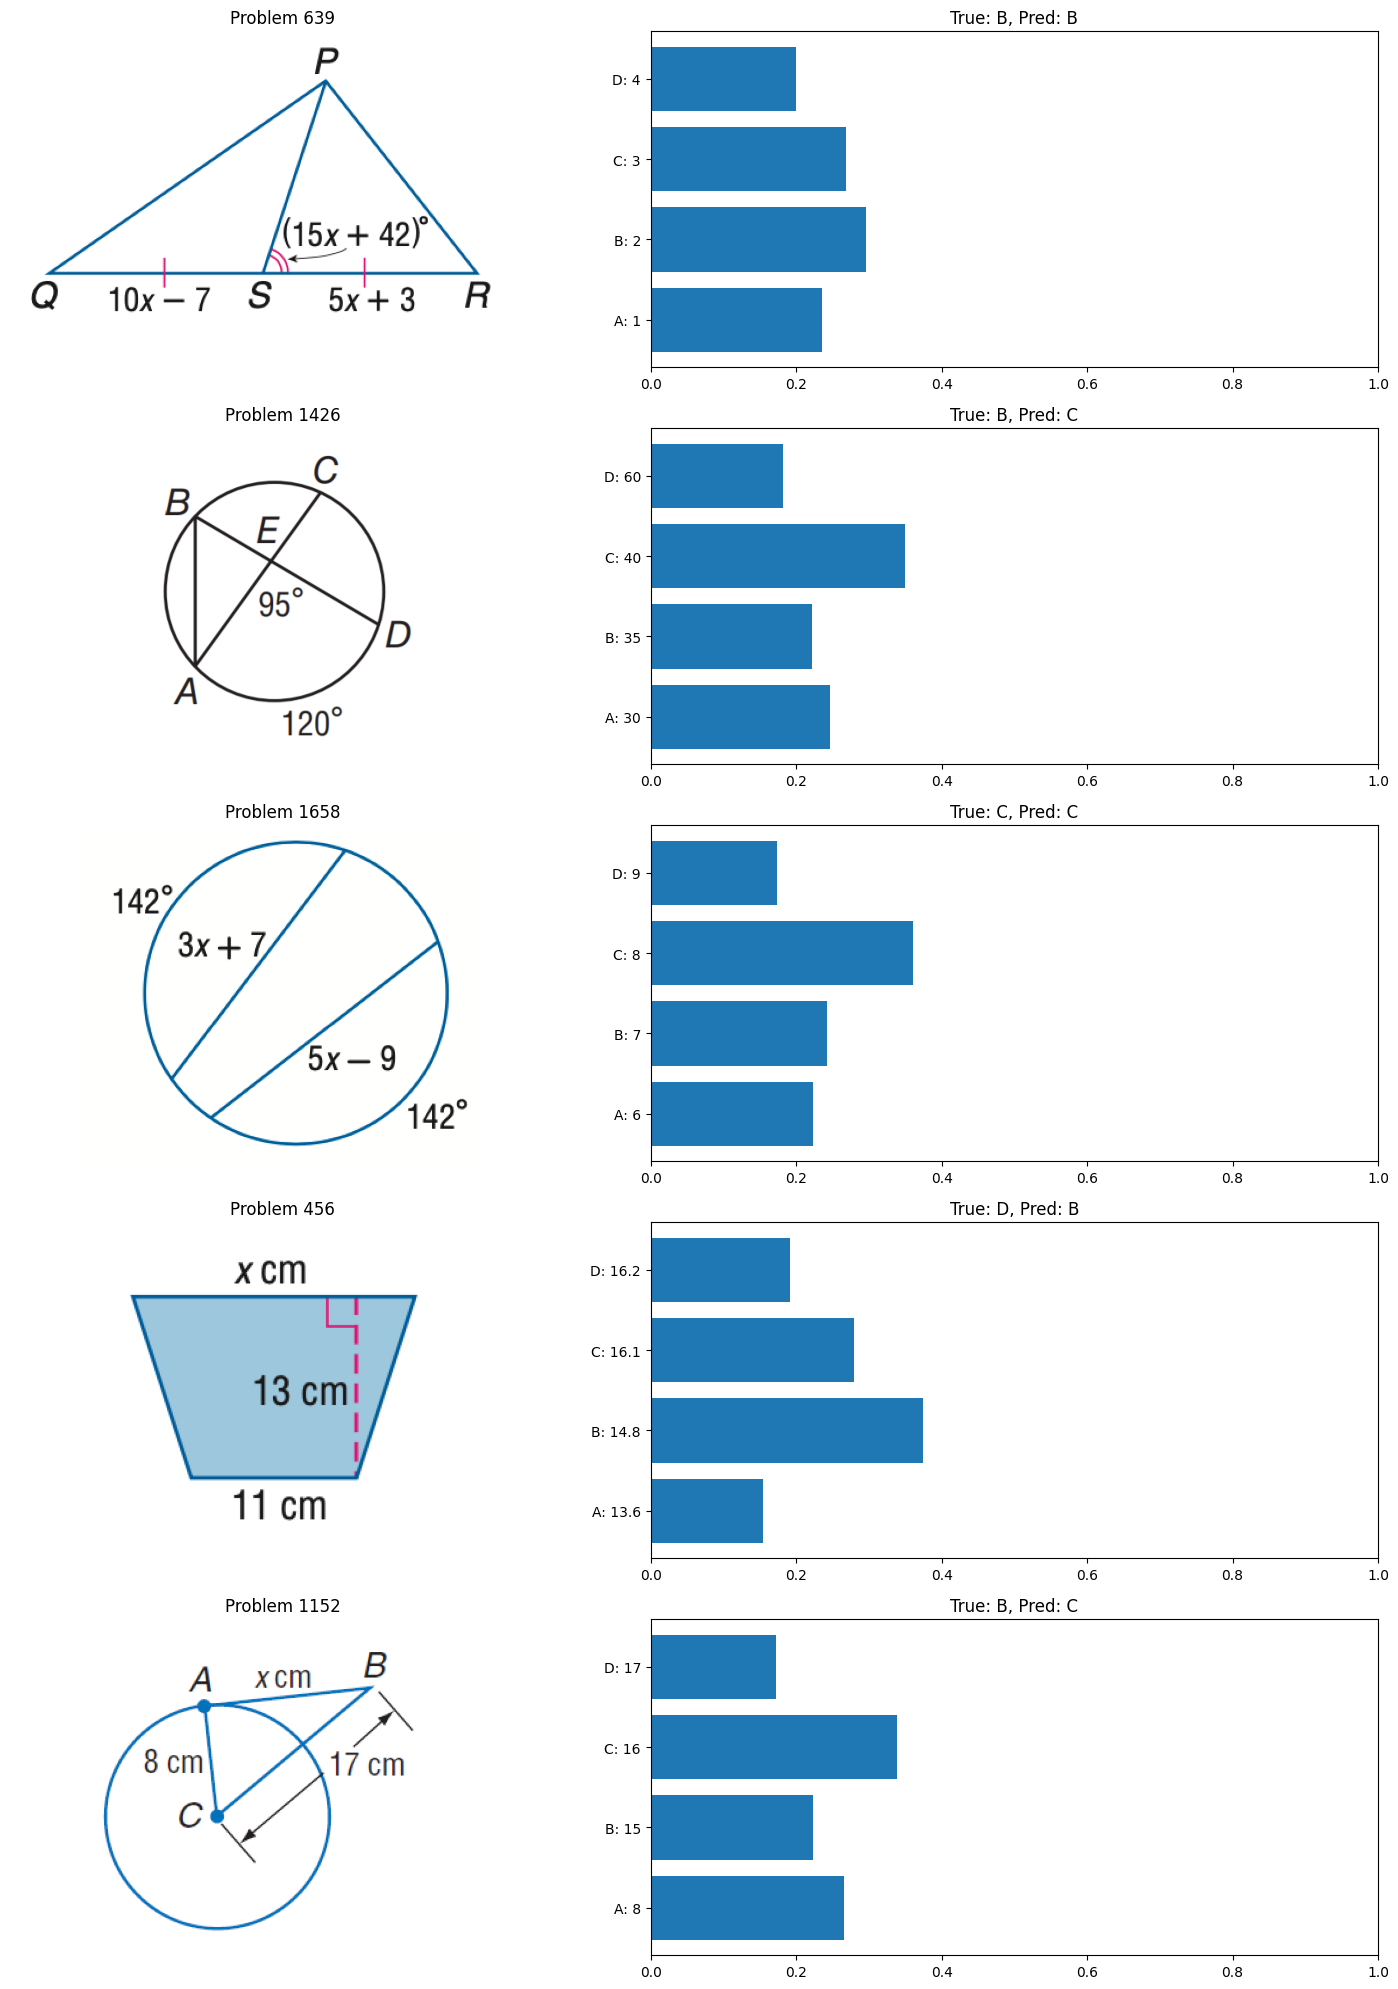

In [11]:
def main():
    # Load model and processor
    model_name = "google/siglip-base-patch16-224"
    processor = AutoProcessor.from_pretrained(model_name)

    # Prepare datasets (with the data augmentation transforms from the previous step)
    train_dataset = Geometry3KDataset(dataset_splits["train"], processor, max_length=64, transform=train_transforms)
    val_dataset = Geometry3KDataset(dataset_splits["validation"], processor, max_length=64, transform=eval_transforms)
    test_dataset = Geometry3KDataset(dataset_splits["test"], processor, max_length=64, transform=eval_transforms)
    
    # Create dataloaders
    batch_size = 16
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Initialize model
    model = GeometryVLM(model_name=model_name).to(device)
    
    # Freeze early layers before training
    freeze_early_layers(model, freeze_text_layers=2, freeze_vision_layers=4)
    
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=2e-5,
        weight_decay=0.01  # added weight decay parameter for regularization
    )
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
    
    # Train the model
    num_epochs = 10
    train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, criterion, scheduler, num_epochs, device)
    
    # Load the best model
    model.load_state_dict(torch.load("best_geometry_model.pth"))
    
    # Evaluate on test set
    test_loss, test_accuracy, test_preds, test_labels = evaluate_model(model, test_dataloader, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # Generate predictions for visualization
    visualize_predictions(model, test_dataset, test_dataloader, processor, num_samples=5)


def visualize_predictions(model, test_dataset, test_dataloader, processor, num_samples=5):
    model.eval()
    
    # Get random indices
    indices = random.sample(range(len(test_dataset)), num_samples)
    
    plt.figure(figsize=(15, 20))
    for i, idx in enumerate(indices):
        # Get the sample
        sample = test_dataset[idx]
        item = test_dataset.dataset[idx]
        
        # Move inputs to device
        inputs = sample["inputs"]
        inputs_device = {k: v.unsqueeze(0).to(device) for k, v in inputs.items()}
        
        # Get prediction
        with torch.no_grad():
            logits = model(inputs_device)
            probs = torch.nn.functional.softmax(logits, dim=1)
            pred_idx = torch.argmax(logits, dim=1).item()
        
        # Get true label
        true_idx = sample["labels"].item()
        
        # Plot the image
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(item['images'][0])
        plt.axis('off')
        plt.title(f"Problem {item['id']}")
        
        # Plot the predictions
        plt.subplot(num_samples, 2, 2*i+2)
        choices = item['choices']
        probs = probs.cpu().numpy()[0]
        labels = [f"{chr(65+j)}: {choices[j]}" for j in range(len(choices))]
        
        plt.barh(labels, probs)
        plt.xlim(0, 1)
        
        # Highlight the correct and predicted answers
        correct_label = chr(65 + true_idx)
        pred_label = chr(65 + pred_idx)
        plt.title(f"True: {correct_label}, Pred: {pred_label}")
        
    plt.tight_layout()
    plt.savefig('prediction_examples.png')
    plt.show()

if __name__ == "__main__":
    main()